In [58]:
# Import all required packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV
from scipy.stats import randint,uniform
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, PrecisionRecallDisplay, average_precision_score,precision_recall_curve,auc
import seaborn as sn
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree  import DecisionTreeClassifier
import warnings

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures,StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import pipeline,set_config
from sklearn.utils import class_weight
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, PrecisionRecallDisplay, precision_score, \
    average_precision_score, auc, precision_recall_curve, make_scorer,SCORERS
from skopt import BayesSearchCV
import datetime, re, sys, holidays
from Functions import *
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math
from sklearn.metrics import mean_squared_error

set_config(display="diagram")
np.random.seed (0)
Parallel(n_jobs=8, max_nbytes=50000)

warnings.filterwarnings("ignore")

In [59]:
categorical_cols = ['Vessel Type']
vessel_cols = ['Total Vessels (Number)', 'Capesize',
                'Capesize Laden', 'Capesize Unladen', 'Panamax', 'Panamax Laden',
                'Panamax Unladen', 'Handymax', 'Handymax Laden', 'Handymax Unladen',
                'Handysize', 'Handysize Laden', 'Handysize Unladen']
# date_cols = ['Berth or Port Entry', 'Date']
date_cols = ['Date']
dwt_cols = ['Total Vessels (DWT)','Capesize (DWT)',
            'Capesize Laden (DWT)', 'Capesize Unladen (DWT)', 'Panamax (DWT)',
            'Panamax Laden (DWT)', 'Panamax Unladen (DWT)', 'Handymax (DWT)',
            'Handymax Laden (DWT)', 'Handymax Unladen (DWT)', 'Handysize (DWT)',
            'Handysize Laden (DWT)', 'Handysize Unladen (DWT)']
weather_cols = ['tempt', 'prcp', 'wspd']

# predict_col = 'Wait Levels'
# numeric_cols = ['Waiting Time (Days)']
predict_col = 'Waiting Time (Days)'

In [60]:
# Get data
data = pd.read_csv('clean_data.csv', index_col=0, parse_dates=date_cols)
weather_df = pd.read_csv('sao_paulo_weather.csv', parse_dates=['date'])
weather_df = weather_df[['date','tavg','prcp','wspd']].rename(columns={'date': 'Date',
                   'tavg': 'tempt',
                   'prcp': 'prcp',
                   'wspd': 'wspd'}, inplace=False)
weather_df = weather_df.fillna(0)
data = data.merge(weather_df, how='inner',left_on=['Date'], right_on=['Date'])

# Drop cols with only 1 value
for col in data.columns:
    if len(data[col].unique()) == 1:
        data.drop(col,axis=1, inplace=True)

data.drop('Berth or Port Entry',axis=1, inplace=True)

#convert DWT cols from obj to int
for col in dwt_cols:
    data[col] = data[col].str.replace(",","").astype(int)
#convert vessel_cols from float to int
for col in vessel_cols:
    data[col] = data[col].astype(int)

#remove rows what were in Q4
# data.drop(data.index[data[predict_col] > 10], inplace=True)

#print cleaned data
data

,IMO,Waiting Time (Days),Vessel Type,Date,Total Vessels (Number),Total Vessels (DWT),Capesize,Capesize Laden,Capesize Unladen,Panamax,...,Handymax (DWT),Handymax Laden (DWT),Handymax Unladen (DWT),Handysize (DWT),Handysize Laden (DWT),Handysize Unladen (DWT),Wait Levels,tempt,prcp,wspd
0,9056399,0.2,3,2015-01-02,16,878272,0,0,0,5,...,432704,121785,310919,52823,30060,22763,0,27.0,0.0,15.1
1,9471252,3.4,2,2015-01-02,16,878272,0,0,0,5,...,432704,121785,310919,52823,30060,22763,1,27.0,0.0,15.1
2,9233399,5.6,3,2015-01-02,16,878272,0,0,0,5,...,432704,121785,310919,52823,30060,22763,2,27.0,0.0,15.1
3,8309141,0.5,1,2015-01-03,17,908718,0,0,0,5,...,474533,107174,367359,70297,36036,34261,0,23.3,3.0,13.8
4,9625970,3.9,2,2015-01-03,17,908718,0,0,0,5,...,474533,107174,367359,70297,36036,34261,1,23.3,3.0,13.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9942,9669392,10.3,3,2021-12-19,47,2880415,0,0,0,22,...,672159,433059,239100,449635,415650,33985,2,17.6,0.0,17.3
9943,9911678,1.9,3,2021-12-28,49,2910427,0,0,0,20,...,870577,552785,317792,465851,308646,157205,0,21.6,0.0,9.8
9944,9476927,2.9,3,2021-12-28,49,2910427,0,0,0,20,...,870577,552785,317792,465851,308646,157205,1,21.6,0.0,9.8
9945,9305219,0.6,2,2021-12-30,47,2744630,0,0,0,17,...,929509,488312,441197,458868,341163,117705,0,20.3,0.0,10.6


In [63]:
# split to train & Test
X_train, X_test, y_train, y_test = train_test_split(data.drop(predict_col,axis=1, inplace=False), data[predict_col], test_size=0.2, random_state=0) # ,stratify=data[predict_col])

Create Pipeline

In [64]:
date_linear_processor = pipeline.Pipeline([('ProcessDates',ProcessDates()),('ProcessHolidays',ProcessHolidays()),('DropDate',DropCol(cols=date_cols))])
numeric_linear_processor = pipeline.Pipeline([('Polynomial',PolynomialFeatures(degree=2,interaction_only =True,include_bias=True)),('Scaler',StandardScaler())])
cat_linear_processor = OneHotEncoder()
vessel_linear_processor = pipeline.Pipeline([('CreateDummyCol',CreateDummyCol()),('ProcessVessel',ProcessVessel(vessel_cols=vessel_cols,dwt_cols=dwt_cols))])
weather_linear_processor = pipeline.Pipeline([('CreateDummyCol',CreateDummyCol()),('ProcessWeather',ProcessWeather()),('ProcessWSpd',ProcessWSpd())])

data_preprocessor = ColumnTransformer([
    # ('numeric_linear_processor',numeric_linear_processor, numeric_cols),
    ('cat_linear_processor',cat_linear_processor, categorical_cols),
    ('date_linear_processor',date_linear_processor, date_cols),
    ('vessel_linear_processor',vessel_linear_processor, vessel_cols+dwt_cols),
    ('weather_linear_processor',weather_linear_processor, weather_cols)
])
data_preprocessor


ColumnTransformer(transformers=[('cat_linear_processor', OneHotEncoder(),
                                 ['Vessel Type']),
                                ('date_linear_processor',
                                 Pipeline(steps=[('ProcessDates',
                                                  ProcessDates()),
                                                 ('ProcessHolidays',
                                                  ProcessHolidays()),
                                                 ('DropDate',
                                                  DropCol(cols=['Date']))]),
                                 ['Date']),
                                ('vessel_linear_processor',
                                 Pipeline(steps=[('CreateDummyCol',
                                                  CreateDummyCol()),
                                                 ('ProcessVessel',
                                                  Process...
                                  'Capesize Unladen (DWT)', 'Panamax (DWT)',
                                  'Panamax Laden (DWT)',
                                  'Panamax Unladen (DWT)', 'Handymax (DWT)',
                                  'Handymax Laden (DWT)',
                                  'Handymax Unladen (DWT)', 'Handysize (DWT)',
                                  'Handysize Laden (DWT)',
                                  'Handysize Unladen (DWT)']),
                                ('weather_linear_processor',
                                 Pipeline(steps=[('CreateDummyCol',
                                                  CreateDummyCol()),
                                                 ('ProcessWeather',
                                                  ProcessWeather()),
                                                 ('ProcessWSpd',
                                                  ProcessWSpd())]),
                                 ['tempt', 'prcp', 'wspd'])])

Regressor model

In [65]:
param_grid = {
    ## Preprocessing parameter options
    # 'columntransformer__date_linear_processor__ProcessDates': [ProcessDates(),None],
    # 'columntransformer__date_linear_processor__ProcessHolidays': [ProcessHolidays(),None],
    # 'columntransformer__weather_linear_processor__ProcessWeather__action': ['actual','drop'],
    # 'columntransformer__weather_linear_processor__ProcessWSpd__action': ['cat','drop'],
    # 'columntransformer__vessel_linear_processor__ProcessVessel__usage': ['dwt','vessel'],


    ## ElasticNet hyper parameters
    # 'ElasticNet__regressor__alpha': np.linspace(0, 1, num=10),
    # 'ElasticNet__regressor__l1_ratio': np.linspace(0, 1, num=10),

    ## XGBoost hyper parameters
    # 'XGBoost__regressor__reg_lambda': [0,0.1,0.5,1,5],
    # 'XGBoost__regressor__n_estimators': [200,400,600,800,1200],
    # 'XGBoost__regressor__learning_rate': np.linspace(0.05, 0.5, num=5),
    # 'XGBoost__regressor__max_depth': [0,5,10,20,30,50,100],

    ## RandomForest hyper parameters
    # 'RandomForest__regressor__min_impurity_decrease': np.linspace(0.1, 0.5, num=4),
    # 'RandomForest__regressor__min_samples_leaf': [2,5,10,20,50],
    # 'RandomForest__regressor__min_samples_split': [2,5,10,20],
    # 'RandomForest__regressor__n_estimators': range(100,400,100),

    ## LGBM hyper parameters
    # 'LGBM__regressor__learning_rate': np.linspace(0.05, 0.5, num=4),
    # 'LGBM__regressor__max_depth': [5,10,50,100],
    # 'LGBM__regressor__n_estimators': [200,500,800],

    ## final estimator LGBM hyper parameters
    # 'final_estimator__boosting_type': ['dart','goss','gbdt'],
    # 'final_estimator__learning_rate': np.linspace(0.05, 0.5, num=5),
    # 'final_estimator__max_depth': [-1,5,10,20,30,50,100],
    # 'final_estimator__n_estimators': [200,400,600,800,1200],

    # test tuner set

    'columntransformer__date_linear_processor__ProcessDates': [ProcessDates()],
    'columntransformer__date_linear_processor__ProcessHolidays': [None],
    'columntransformer__weather_linear_processor__ProcessWeather__action': ['actual'],
    'columntransformer__weather_linear_processor__ProcessWSpd__action': ['cat'],
    'columntransformer__vessel_linear_processor__ProcessVessel__usage': ['vessel'],
    'XGBoost__regressor__max_depth': [20,100],
    'RandomForest__regressor__n_estimators': range(100,400,100),
    'LGBM__regressor__n_estimators': [200,500,800],
    'final_estimator__n_estimators': [200,500,800],
    'ElasticNet__regressor__alpha': np.linspace(0, 1, num=2),
}

In [66]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm  import LGBMRegressor
from sklearn.ensemble import StackingRegressor
estimators = [
    ("ElasticNet", ElasticNet(random_state=0)),
    ("XGBoost", XGBRegressor(objective='reg:squarederror',random_state=0,n_jobs=-1,use_label_encoder=False,  tree_method = 'gpu_hist')),#,eval_metric='r2'
    ("RandomForest", RandomForestRegressor(random_state=0,n_jobs=-1)),
    ("LGBM", LGBMRegressor(objective='regression',random_state=0,n_jobs=-1,device = 'gpu')),
]
finalestimators = []
for estimator, model in estimators:
    finalestimators.append((estimator,pipeline.Pipeline([('columntransformer',data_preprocessor),('DropZeroCol',DropZeroCol()),('regressor',model)])))
final_estimator=LGBMRegressor(objective='regression',random_state=0,n_jobs=-1,device = 'gpu')
stacking_Regressor = StackingRegressor(estimators=finalestimators, final_estimator=final_estimator,n_jobs=-1)
# finalPipe = pipeline.make_pipeline(data_preprocessor,stacking_Regressor)
finalPipe = stacking_Regressor

In [67]:
finalPipe

StackingRegressor(estimators=[('ElasticNet',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('cat_linear_processor',
                                                                                 OneHotEncoder(),
                                                                                 ['Vessel '
                                                                                  'Type']),
                                                                                ('date_linear_processor',
                                                                                 Pipeline(steps=[('ProcessDates',
                                                                                                  ProcessDates()),
                                                                                                 ('ProcessHolidays',
                                                                                                  ProcessHolidays()),
                                                                                                 ('DropDate',
                                                                                                  DropCol(cols=['Date']))]),
                                                                                 ['Date']),
                                                                                ('vessel_linear_proc...
                                                                                 Pipeline(steps=[('CreateDummyCol',
                                                                                                  CreateDummyCol()),
                                                                                                 ('ProcessWeather',
                                                                                                  ProcessWeather()),
                                                                                                 ('ProcessWSpd',
                                                                                                  ProcessWSpd())]),
                                                                                 ['tempt',
                                                                                  'prcp',
                                                                                  'wspd'])])),
                                               ('DropZeroCol', DropZeroCol()),
                                               ('regressor',
                                                LGBMRegressor(device='gpu',
                                                              objective='regression',
                                                              random_state=0))]))],
                  final_estimator=LGBMRegressor(device='gpu',
                                                objective='regression',
                                                random_state=0),
                  n_jobs=-1)

In [ ]:
#tune hyperparameter
limitTuner = '' # Options ElasticNet, XGBoost, RandomForest, LGBM
preprocessingName = 'columntransformer__'
estimatorsParam = {}
finalParam = {}
for estimator in finalestimators:
    if limitTuner== '' or estimator[0] ==limitTuner:
        modelParam = {}
        for param, grid in param_grid.items():
            if param.startswith(estimator[0]):
                modelParam[param[len(estimator[0])+2:]] = grid
            elif param.startswith(preprocessingName):
                modelParam[param] = grid
        # print(estimator[1].get_params().keys())
        print('\nTuning Model ',estimator[0], "with params:\n",  modelParam, '\n')
        gs = GridSearchCV(estimator=estimator[1],param_grid=modelParam,scoring = 'neg_root_mean_squared_error',n_jobs = -1,cv = 5,verbose = 10)
        gs.fit(X_train,y_train)
        print('Tuned Model ',estimator[0], " (RMSE = ","{:.4f}".format(abs(gs.best_score_)),")")
        # print("Best params:\n",  gs.best_params_, '\n')
        modelParam={}
        for param, grid in gs.best_params_.items():
            modelParam[estimator[0]+'__'+param] = grid
        estimatorsParam ={**estimatorsParam, **modelParam}

print('\n Params to use\n\n',estimatorsParam)

Stop Here

# replace individual best model here post tuning.
elasticnetParams = {}
xgboostParams = {}
randomforestParams = {}
lgbmParams = {}


# prepare data for final tuning
# estimatorsParam = {**elasticnetParams,**xgboostParams,**randomforestParams,**lgbmParams,}
finalPipe.set_params(**estimatorsParam)
finalTrain  = finalPipe.fit_transform(X_train,y_train)
finalGrid = {}

# generate final model params
for param, grid in param_grid.items():
    if param.startswith("final_estimator"):
        finalGrid[param[len("final_estimator__"):]] = grid

#tune final model
gs = GridSearchCV(estimator=final_estimator,param_grid=finalGrid,scoring = 'neg_root_mean_squared_error',n_jobs = -1,cv = 5,verbose = -1)
gs.fit(finalTrain,y_train)
modelParam = {}
for param, grid in gs.best_params_.items():
    modelParam["final_estimator__"+param] = grid
finalParam = {**estimatorsParam, **modelParam}
finalParam

In [68]:
# finalParam = {'ElasticNet__columntransformer__date_linear_processor__ProcessDates': ProcessDates(),
#  'ElasticNet__columntransformer__date_linear_processor__ProcessHolidays': None,
#  'ElasticNet__columntransformer__vessel_linear_processor__ProcessVessel__usage': 'dwt',
#  'ElasticNet__columntransformer__weather_linear_processor__ProcessWSpd__action': 'cat',
#  'ElasticNet__columntransformer__weather_linear_processor__ProcessWeather__action': 'actual',
#  'ElasticNet__regressor__alpha': 0.0,
#  'XGBoost__columntransformer__date_linear_processor__ProcessDates': ProcessDates(),
#  'XGBoost__columntransformer__date_linear_processor__ProcessHolidays': None,
#  'XGBoost__columntransformer__vessel_linear_processor__ProcessVessel__usage': 'dwt',
#  'XGBoost__columntransformer__weather_linear_processor__ProcessWSpd__action': 'cat',
#  'XGBoost__columntransformer__weather_linear_processor__ProcessWeather__action': 'actual',
#  'XGBoost__regressor__max_depth': 20,
#  'RandomForest__columntransformer__date_linear_processor__ProcessDates': ProcessDates(),
#  'RandomForest__columntransformer__date_linear_processor__ProcessHolidays': None,
#  'RandomForest__columntransformer__vessel_linear_processor__ProcessVessel__usage': 'vessel',
#  'RandomForest__columntransformer__weather_linear_processor__ProcessWSpd__action': 'cat',
#  'RandomForest__columntransformer__weather_linear_processor__ProcessWeather__action': 'actual',
#  'RandomForest__regressor__n_estimators': 300,
#  'LGBM__columntransformer__date_linear_processor__ProcessDates': ProcessDates(),
#  'LGBM__columntransformer__date_linear_processor__ProcessHolidays': None,
#  'LGBM__columntransformer__vessel_linear_processor__ProcessVessel__usage': 'vessel',
#  'LGBM__columntransformer__weather_linear_processor__ProcessWSpd__action': 'cat',
#  'LGBM__columntransformer__weather_linear_processor__ProcessWeather__action': 'actual',
#  'LGBM__regressor__n_estimators': 800,
#  # 'final_estimator__n_estimators': 200}

In [69]:
finalParam = {'ElasticNet__columntransformer__date_linear_processor__ProcessDates': ProcessDates(),
 'ElasticNet__columntransformer__date_linear_processor__ProcessHolidays': None,
 'ElasticNet__columntransformer__vessel_linear_processor__ProcessVessel__usage': 'dwt',
 'ElasticNet__columntransformer__weather_linear_processor__ProcessWSpd__action': 'cat',
 'ElasticNet__columntransformer__weather_linear_processor__ProcessWeather__action': 'actual',
 'XGBoost__columntransformer__date_linear_processor__ProcessDates': ProcessDates(),
 'XGBoost__columntransformer__date_linear_processor__ProcessHolidays': None,
 'XGBoost__columntransformer__vessel_linear_processor__ProcessVessel__usage': 'dwt',
 'XGBoost__columntransformer__weather_linear_processor__ProcessWSpd__action': 'cat',
 'XGBoost__columntransformer__weather_linear_processor__ProcessWeather__action': 'actual',
 'RandomForest__columntransformer__date_linear_processor__ProcessDates': ProcessDates(),
 'RandomForest__columntransformer__date_linear_processor__ProcessHolidays': None,
 'RandomForest__columntransformer__vessel_linear_processor__ProcessVessel__usage': 'vessel',
 'RandomForest__columntransformer__weather_linear_processor__ProcessWSpd__action': 'cat',
 'RandomForest__columntransformer__weather_linear_processor__ProcessWeather__action': 'actual',
 'LGBM__columntransformer__date_linear_processor__ProcessDates': ProcessDates(),
 'LGBM__columntransformer__date_linear_processor__ProcessHolidays': None,
 'LGBM__columntransformer__vessel_linear_processor__ProcessVessel__usage': 'vessel',
 'LGBM__columntransformer__weather_linear_processor__ProcessWSpd__action': 'cat',
 'LGBM__columntransformer__weather_linear_processor__ProcessWeather__action': 'actual',}

In [70]:
resultList = []
def ScoreArray(trainPredicted,testPredicted):
    trainrmse = math.sqrt(mean_squared_error(y_train, trainPredicted))
    trainr2 = r2_score(y_train, trainPredicted)
    mae = mean_absolute_error(y_test, testPredicted)
    rmse = math.sqrt(mean_squared_error(y_test, testPredicted))
    r2 = r2_score(y_test, testPredicted)
    return [trainrmse,trainr2,mae,rmse,r2]

finalPipe.set_params(**finalParam)
finalPipe.fit(X_train,y_train)
trainTrans = finalPipe.transform(X_train)
testTrans = finalPipe.transform(X_test)
i=0
for estimator in finalestimators:
    resultList.append((estimator[0],ScoreArray(trainTrans[:,i],testTrans[:,i])))
    i+=1
trainPredicted = finalPipe.predict(X_train)
testPredicted = finalPipe.predict(X_test)
resultList.append(("Stack Regressor",ScoreArray(trainPredicted,testPredicted)))

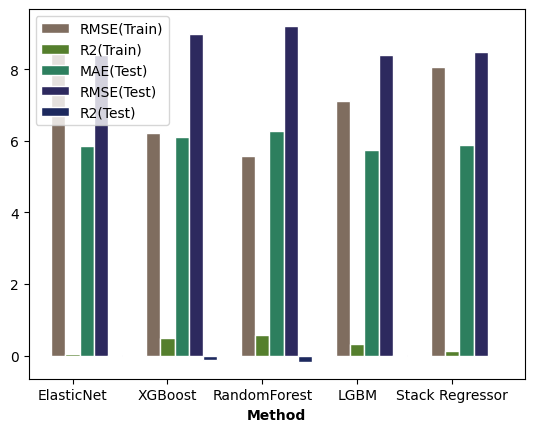

             ElasticNet   XGBoost  RandomForest      LGBM  Stack Regressor
RMSE(Train)    8.513447  6.215526      5.578854  7.119176         8.073242
R2(Train)      0.034342  0.485283      0.585330  0.324739         0.131623
MAE(Test)      5.862856  6.105690      6.284335  5.753626         5.882765
RMSE(Test)     8.397182  8.990257      9.210556  8.395039         8.487926
R2(Test)       0.019719 -0.123641     -0.179384  0.020219        -0.001582


In [71]:
barWidth = 0.15

# set heights of bars
names = []
bars = [[],[],[],[],[]]
for name,result in resultList:
    names.append(name)
    bars[0].append(result[0])
    bars[1].append(result[1])
    bars[2].append(result[2])
    bars[3].append(result[3])
    bars[4].append(result[4])

# Set position of bar on X axis
r1 = np.arange(len(bars[0]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

# Make the plot
finalPlotLabels = ['RMSE(Train)','R2(Train)','MAE(Test)', 'RMSE(Test)', 'R2(Test)']
colours = ['#7f6d5f','#557f2d','#2d7f5e','#2d295e','#1d295e']
r = [r1,r2,r3,r4,r5]
i=0
for finalPlotLabel in finalPlotLabels:
    plt.bar(r[i], bars[i], color=colours[i], width=barWidth, edgecolor='white', label=finalPlotLabel)
    i+=1

# Add xticks on the middle of the group bars
plt.xlabel('Method', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[0]))], names)

# Create legend & Show graphic
plt.legend()
plt.show()

print(pd.DataFrame(bars,columns=names,index=finalPlotLabels))

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
def ScoreArray(trainPredicted,testPredicted):
    trainrmse = math.sqrt(mean_squared_error(y_train, trainPredicted))
    mae = mean_absolute_error(y_test, testPredicted)
    rmse = math.sqrt(mean_squared_error(y_test, testPredicted))
    r2 = r2_score(y_test, testPredicted)
    return [trainrmse,mae,rmse,r2]
def ScoreArrayalt(trainPredicted,testPredicted):
    trainrmse = math.sqrt(mean_squared_error(y_train, trainPredicted))
    mae = mean_absolute_error(alt_y_test, testPredicted)
    rmse = math.sqrt(mean_squared_error(alt_y_test, testPredicted))
    r2 = r2_score(alt_y_test, testPredicted)
    return [trainrmse,mae,rmse,r2]

In [ ]:
clf = finalestimators[3][1]
# clf
# clf= pipeline.Pipeline([('columntransformer',data_preprocessor),('DropZeroCol',DropZeroCol()),('regressor',ElasticNet(random_state=0))])
clf.set_params(**{'columntransformer__vessel_linear_processor__ProcessVessel__usage': 'vessel'})


alt_y_train = y_train.apply(np.log).apply(np.log)
alt_y_test = y_test.apply(np.log).apply(np.log)

clf.fit(X_train,y_train)
clftrainPredicted = clf.predict(X_train)
clftestPredicted = clf.predict(X_test)
print(ScoreArray(clftrainPredicted,clftestPredicted))


clf.fit(X_train,alt_y_train)
clftrainPredicted = clf.predict(X_train)
clftestPredicted = clf.predict(X_test)
print(ScoreArrayalt(clftrainPredicted,clftestPredicted))

In [ ]:
log_y_train = y_train.apply(np.log)

In [ ]:
np.log

In [ ]:

finalPipe.transform(X_test)

In [ ]:

finalPipe.predict(X_test)

In [ ]:
pd.DataFrame(y_test)